phi: 0.505 | uniform size: (29, 29)
Manipulator at [0, 49]


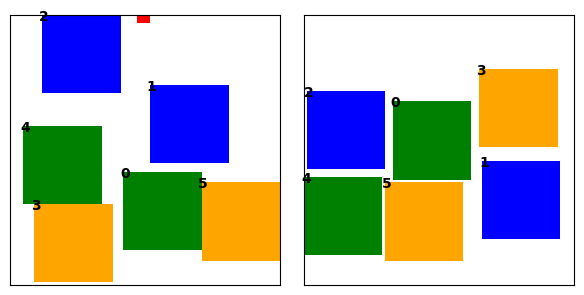

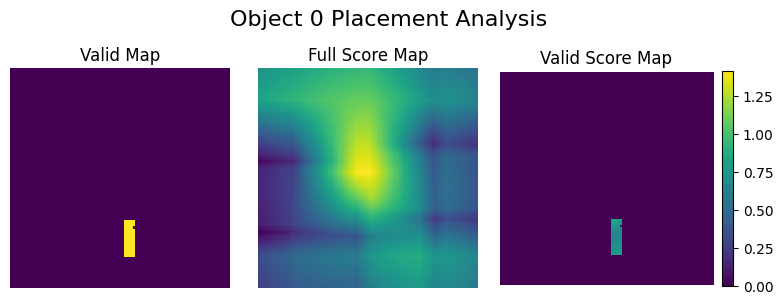

In [1]:
import os
import time
import json
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Tuple, Optional, Dict
from tqdm import tqdm
import seaborn as sns
import cProfile, pstats
from pandas.api.types import CategoricalDtype
from matplotlib import colormaps

import heapq
from core.env.scene_manager import SceneManager, show_valid_score_map, draw_dependency_graph
from core.env.scene_manager import (
	Indices, copy_state, state_to_hashable,
    get_object_below, get_object_above, get_object_base, build_parent_of
)
from core.planners.utils import BaseSearch, env_cost, evaluate_alg, reconstruct_path, refine_until_convergence

phi = 0.5
num_objects = 6
grid_size = (100, 100)

env = SceneManager(
	mode='mobile', num_objects=num_objects, 
	grid_size=grid_size, phi=phi, verbose=1
)
env.reset(use_stack=False, use_sides=False)
initial_scene, target_scene = env.initial_x.clone(), env.target_x.clone()
# with open(f'example_phi{phi}_n{num_objects}.pkl', 'rb') as f:
# with open(f'shit.pkl', 'rb') as f:
# 	scenes = pickle.load(f)
# 	initial_scene = scenes["initial"].to(torch.long)
# 	target_scene = scenes["target"].to(torch.long)
env.reset(initial_scene, target_scene)
env.render(show_manipulator=True, fig_size=3)
show_valid_score_map(env, obj=0)
# draw_dependency_graph(env, fig_size=(3, 3))

In [2]:
from core.planners.Labbe import Labbe, Labbe_S

class AstarNode:
	def __init__(self, 
			state: Dict[str, torch.Tensor], 
			parent: Optional[int]=None, 
			action: Optional[int]=None, 
			g_cost: float=0.0, 
			h_cost: float=0.0, 
			depth: int=0
		):
		self.state = state
		self.parent = parent
		self.action = action
		self.g_cost = g_cost	# cost-to-come
		self.h_cost = h_cost	# cost-to-go
		self.total_cost = self.g_cost + self.h_cost
		self.depth = depth

	def __lt__(self, other):
		return self.total_cost < other.total_cost  # Lower cost first

	def get_state(self) -> Dict[str, torch.Tensor]:
		return copy_state(self.state)

class Astar(BaseSearch):
	def __init__(self, env: 'SceneManager'):
		super().__init__(env, AstarNode)
	
	def get_remaining_objs(self, state: Dict[str, torch.Tensor]) -> List[int]:
		raise NotImplementedError
	
	def get_valid_actions(self, state: Dict[str, torch.Tensor]) -> List[int]:
		raise NotImplementedError
	
	def evaluate_state(self, state: Dict[str, torch.Tensor]) -> float:
		raise NotImplementedError
	
	def _solve(self, time_limit: int=1000):
		start_time = time.time()
		
		steps = 0
		root_state = self.env.get_state()
		root_node = self.node_class(
			state=root_state, 
			g_cost=0, 
			h_cost=self.evaluate_state(root_state)
		)

		self.queue = []
		heapq.heappush(self.queue, root_node)
		visited = {}

		while self.queue:
			current_node = heapq.heappop(self.queue)

			# Check if the current node's state matches the target state
			if self.env.is_terminal_state(current_node.state):
				return reconstruct_path(current_node), steps, time.time()-start_time

			# Check if the elapsed time has exceeded the limit
			if time.time()-start_time > time_limit:
				# print('Time limit exceeded')
				return None, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.state):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed obj is the same as the current obj, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['current'], current_node.state['current']):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_g_cost = current_node.g_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_g_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						g_cost=new_g_cost, 
						h_cost=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(self.queue, child_node)

		return None, steps, time.time()-start_time

num_runs = 3
score_sorting = False
num_buffers = 4
time_limit = 20

In [ ]:
class Strap(Astar):
	def get_remaining_objs(self, state: Dict[str, torch.Tensor]) -> List[int]:
		"""
		Objects whose current center ≠ target center.
		"""
		current_x, target_x = state['current'], self.env.target_x

		# All current vs. target centers: [N,2]
		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]

		# Base condition for objs that should be on the table
		satisfied = (cur_centers == tgt_centers).all(dim=1)  # [N]

		# Remaining = those not satisfied
		rem = torch.nonzero(~satisfied, as_tuple=False).view(-1)  # [R]

		if rem.numel() == 0:
			return []

		# Shuffle the remaining indices
		perm = torch.randperm(rem.size(0))
		return rem[perm].tolist()

	def get_valid_actions(self, state: Dict[str, torch.Tensor]) -> List[int]:
		"""
		For each object k that’s not yet in place,
		gather up to self.num_buffers candidate coords
		(including its target if free), and batch‐encode
		all those 'move' actions at once.
		"""
		# restore the env to this state
		self.env.set_state(copy_state(state))

		# which objects remain to be placed?
		rem = self.get_remaining_objs(state)

		# for each remaining object, batch‐fetch positions & encode
		valid_actions = []
		for k in rem:
			# coords: Tensor of shape [M,2], dtype long
			coords = self.env.get_empty_positions_with_target(
				ref_obj=k,
				n=self.num_buffers,
				sort=self.score_sorting
			)

			if coords.numel() == 0:
				continue

			# build batched start/target vectors of length M
			M      = coords.size(0)
			starts = torch.full((M,), k, dtype=torch.long)

			# vectorized call: returns LongTensor[M]
			codes  = self.env.encode_move(starts, coords)
			valid_actions.append(codes)

		if len(valid_actions) == 0:
			return []

		# concatenate all batches and return Python ints
		return torch.cat(valid_actions).tolist()

	def evaluate_state(self, state: Dict[str, torch.Tensor]) -> float:
		"""
		Heuristic = sum over all remaining k of:
		pp_cost + normalized_distance( current_pos[k], target_pos[k] ).
		"""
		current_x, target_x = state['current'], self.env.target_x

		# 1) remaining object indices [R]
		rem_nodes = torch.tensor(self.get_remaining_objs(state), dtype=torch.long)
		if rem_nodes.numel() == 0:
			return 0.0

		# 2) Gather current and target centers for those nodes: [R,2]
		cur_ctr = current_x[rem_nodes, Indices.COORD].float()
		tgt_ctr = target_x[rem_nodes, Indices.COORD].float()

		# 3) Euclidean distances [R]
		dists   = torch.cdist(cur_ctr, tgt_ctr, p=2).diag()  # [R]
		
		# 4) Heuristic = R * pp_cost + sum(dists) * normalization
		R       = float(rem_nodes.size(0))
		pp      = env.pp_cost
		norm    = env.normalization_factor

		return R * pp + (dists.sum().item() * norm)

	def solve(self, num_buffers: int=3, score_sorting: bool=False, time_limit: int=1000):
		if torch.sum(self.env.initial_x[:, Indices.RELATION]) > 0:
			raise ValueError('Initial scene has stacks in Non-stack mode')
		if torch.sum(self.env.current_x[:, Indices.RELATION]) > 0:
			raise ValueError('Current scene has stacks in Non-stack mode')
		if torch.sum(self.env.target_x[:, Indices.RELATION]) > 0:
			raise ValueError('Target scene has stacks in Non-stack mode')
		
		self.score_sorting = score_sorting
		self.num_buffers = num_buffers
		return self._solve(time_limit)

class StrapGA(Strap):
	def goal_attempt(self, node, time_limit: int) -> int:
		self.env.set_state(node.get_state())
		plan_to_go, steps, _ = Labbe(self.env).solve(time_limit=time_limit)

		# no feasible plan was found in the time_limit
		if plan_to_go is None:
			return steps

		# --- Stage 1: Immediate Redundancy Removal ---
		decoded_plan = []
		for action in plan_to_go:
			decoded_action = (action, self.env.decode_action(action))
			# each entry: (action, (action_type, start_obj, target_obj, coord))
			# remove redundant action on the latest manipulated object
			# This check is for consecutive actions on the SAME object.
			# It keeps the last action on that object and discards previous consecutive ones.
			if len(decoded_plan) > 0 and decoded_action[1][1] == decoded_plan[-1][1][1]:
				decoded_plan[-1] = decoded_action
			else:
				decoded_plan.append(decoded_action)

		# --- Stage 2: State-Checking Redundancy (Simulate and Filter) ---
		# This stage is only required after the immediate redundancy removal
		self.env.set_state(node.get_state())
		feasible_path_cost = node.g_cost
		refined_plan = []

		for i, decoded_action in enumerate(decoded_plan):
			action = decoded_action[0]
			action_type, start_obj, target_obj, coordinates = decoded_action[1]
			
			if action_type == 'stack':
				# If the object is already stacked, skip this action
				if self.env.current_x[start_obj, Indices.RELATION.start + target_obj] == 1:
					continue
			elif action_type == 'move':
				# If the object is ALREADY at the target coordinates for this move action.
				current_coord = self.env.current_x[start_obj, Indices.COORD]
				if torch.equal(current_coord, coordinates):
					continue

			refined_plan.append(action)
			cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

			feasible_path_cost += cost
			if i == 0:
				first_child = child_state
				first_action = action
				first_cost = feasible_path_cost

		# --- Stage 3: add the first child node if the plan is the best so far ---
		if feasible_path_cost < self.best_cost:
			self.best_plan = reconstruct_path(node) + list(refined_plan)
			self.best_cost = feasible_path_cost
			child_node = self.node_class(
				state=first_child,
				parent=node,
				action=first_action,
				g_cost=first_cost,
				h_cost=self.evaluate_state(first_child),
				depth=node.depth+1
			)

			heapq.heappush(self.queue, child_node)

		# Remove all the nodes with their total cost is greater than the feasible path cost
		# for node in self.queue:
		# 	if node.total_cost > feasible_path_cost:
		# 		self.queue.remove(node)

		return steps

	def _solve(self, time_limit: int=1000):
		start_time = time.time()
		self.best_plan = None
		self.best_cost = float('inf')

		steps = 0
		root_state = self.env.get_state()
		root_node = self.node_class(
			state=root_state, 
			g_cost=0, 
			h_cost=self.evaluate_state(root_state)
		)

		self.queue = []
		heapq.heappush(self.queue, root_node)
		visited = {}

		while self.queue:
			current_node = heapq.heappop(self.queue)

			# Check if the current node's state matches the target state
			if self.env.is_terminal_state(current_node.state):
				if current_node.total_cost < self.best_cost:
					return reconstruct_path(current_node), steps, time.time()-start_time
				return self.best_plan, steps, time.time()-start_time

			# Check if the elapsed time has exceeded the limit
			if time.time()-start_time > time_limit:
				# print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.state):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed obj is the same as the current obj, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['current'], current_node.state['current']):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_g_cost = current_node.g_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_g_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						g_cost=new_g_cost, 
						h_cost=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(self.queue, child_node)

			if time.time()-start_time > time_limit:
				# print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			# Goal Attempting
			sim_time_limit = (time_limit - time.time() + start_time) / 5
			steps += self.goal_attempt(current_node, sim_time_limit)

		return self.best_plan, steps, time.time()-start_time

# prof = cProfile.Profile()
# prof.enable()
# evaluate_alg(
# 	env, StrapGA, initial_scene, target_scene, 
# 	num_runs=num_runs, score_sorting=score_sorting,
# 	num_buffers=num_buffers, time_limit=time_limit
# );
# prof.disable()
# pstats.Stats(prof).sort_stats('tottime').print_stats(30);

In [7]:
class Strap_S(Astar):
	def get_remaining_objs(self, state: Dict[str, torch.Tensor]) -> List[int]:
		"""
		• Objects whose aren't stacked on their target objects.
		• Base objects whose current center ≠ target center.
		"""
		current_x, target_x = state['current'], self.env.target_x

		# Build parent‐of maps once
		cur_parent = build_parent_of(current_x)

		# Stacking condition for objs that should be stacked
		cond_stacked = (self.tgt_parent >= 0) & (cur_parent == self.tgt_parent)

		# Base condition for objs that should be on the table
		cur_centers = current_x[:, Indices.COORD]
		tgt_centers = target_x[:, Indices.COORD]
		base_match = (cur_centers == tgt_centers).all(dim=1)  # [N]
		cond_base    = (self.tgt_parent < 0) & (cur_parent < 0) & base_match

		# Satisfied = either stacking OK or base OK
		satisfied = cond_stacked | cond_base       # [N]

		# Remaining = those not satisfied
		rem = torch.nonzero(~satisfied, as_tuple=False).view(-1)  # [R]

		if rem.numel() == 0:
			return []

		# Shuffle the remaining indices
		perm = torch.randperm(rem.size(0))
		return rem[perm].tolist()

	def get_valid_actions(self, state: Dict[str, torch.Tensor]) -> List[int]:
		"""
		...
		"""
		# restore the env to this state
		self.env.set_state(copy_state(state))

		# which objects remain to be placed?
		rem = self.get_remaining_objs(state)

		# Which k are allowed (static_stack skips non‐empty actors)
		if self.static_stack:
			rem = torch.tensor(rem, dtype=torch.long)
			rel     = self.env.current_x[:, Indices.RELATION]
			empty_k = ~rel.any(dim=0)                  # True if k has no one on top
			mask = empty_k[rem]
			ks = rem[mask].tolist()
		else:
			ks = rem

		valid_actions = []
		stack_nums = max(int(0.6 * self.num_buffers), 1)

		for k in ks:
			valid_stacks = []
			empty_objs = self.env.get_empty_objs(ref_obj=k, n=stack_nums)
			if len(empty_objs) > 0:
				M      = len(empty_objs)
				starts = torch.full((M,), k, dtype=torch.long)
				targets= torch.tensor(empty_objs, dtype=torch.long)
				valid_stacks = self.env.encode_stack(starts, targets).tolist()

			valid_moves = []
			coords = self.env.get_empty_positions_with_target(
				ref_obj=k,
				n=self.num_buffers-len(valid_stacks),
				sort=self.score_sorting
			)

			if coords.numel() > 0:
				M      = coords.size(0)
				starts = torch.full((M,), k, dtype=torch.long)
				valid_moves  = self.env.encode_move(starts, coords).tolist()

			valid_actions += valid_stacks + valid_moves

		return valid_actions

	def evaluate_state2(self, state: Dict[str, torch.Tensor]) -> float:
		"""
		Heuristic for each remaining object k:
			Aₖ = dist(Cₖ → Tₖ) * NF
			Bₖ = min_j [ dist(Cₖ → Cⱼ) + dist(Tⱼ → Tₖ) ] * NF + pp_cost
				(only over supporting j)
		Final h = sum_k ( min(Aₖ, Bₖ) + pp_cost )
		"""
		cur_x, tgt_x  = state['current'], self.env.target_x
		pp_cost, norm = self.env.pp_cost, self.env.normalization_factor

		# Remaining indices
		rem = torch.tensor(self.get_remaining_objs(state), dtype=torch.long)
		if rem.numel() == 0:
			return 0.0

		# Gather current & target centers for remaining: [R,2]
		cur_ctr = cur_x[rem, Indices.COORD].float()  # [R,2]
		tgt_ctr = tgt_x[rem, Indices.COORD].float()  # [R,2]

		# Compute A = direct move distance
		A = torch.cdist(cur_ctr, tgt_ctr, p=2).diag() * norm     # [R]

		# Precompute all object centers
		all_cur = cur_x[:, Indices.COORD].float()    # [N,2]
		all_tgt = tgt_x[:, Indices.COORD].float()    # [N,2]

		# Pairwise distances
		D_c = torch.cdist(cur_ctr, all_cur, p=2)  # cost C_k→C_j: [R,N]
		D_t = torch.cdist(tgt_ctr, all_tgt, p=2)  # cost T_k→T_j: [R,N]

		# Stability mask for rem rows
		S_rem = self.env.stability_mask[rem]      # [R,N]

		# Compute stack‐move costs and invalidate unsupportable pairs
		costs = D_c + D_t                   # [R,N]
		costs[~S_rem] = float('inf')        # forbid non‐stable

		# B = min_j costs[r,j] * norm + pp_cost
		B = costs.min(dim=1).values * norm + pp_cost           # [R]

		# Per‐object best cost = min(A, B) + pp_cost
		best = torch.minimum(A, B) + pp_cost                 # [R]

		# Final h_cost
		return best.sum()

	def evaluate_state(self, state: Dict[str, torch.Tensor]) -> float:
		"""
		Heuristic for each remaining object k:
			Aₖ = dist(Cₖ → Tₖ) * NF
			Bₖ = min_j [ dist(Cₖ → Cⱼ) ] * NF + pp_cost
				(only over supporting j)
		Final h = sum_k ( min(Aₖ, Bₖ) + pp_cost )
		"""
		cur_x, tgt_x  = state['current'], self.env.target_x
		pp_cost, norm = self.env.pp_cost, self.env.normalization_factor

		# Remaining indices
		rem = torch.tensor(self.get_remaining_objs(state), dtype=torch.long)
		if rem.numel() == 0:
			return 0.0

		# Gather current & target centers for remaining: [R,2]
		cur_ctr = cur_x[rem, Indices.COORD].float()  # [R,2]
		tgt_ctr = tgt_x[rem, Indices.COORD].float()  # [R,2]

		# Compute A = direct move distance
		A = torch.cdist(cur_ctr, tgt_ctr, p=2).diag() * norm     # [R]

		# Precompute all object centers
		all_cur = cur_x[:, Indices.COORD].float()    # [N,2]

		# Pairwise distances
		costs = torch.cdist(cur_ctr, all_cur, p=2)  # cost C_k→C_j: [R,N]

		# Stability mask for rem rows
		S_rem = self.env.stability_mask[rem]      # [R,N]

		# Compute stack‐move costs and invalidate unsupportable pairs
		costs[~S_rem] = float('inf')        # forbid non‐stable

		# B = min_j costs[r,j] * norm + pp_cost
		B = costs.min(dim=1).values * norm + pp_cost           # [R]

		# Per‐object best cost = min(A, B) + pp_cost
		best = torch.minimum(A, B) + pp_cost                 # [R]

		# Final h_cost
		return best.sum()

	def solve(self, num_buffers: int=4, score_sorting: bool=False, time_limit: int=1000, static_stack: bool=False):
		self.tgt_parent = build_parent_of(self.env.target_x)
		self.score_sorting = score_sorting
		self.num_buffers = num_buffers
		self.static_stack = static_stack
		self.env.static_stack = static_stack
		return self._solve(time_limit)

class StrapGA_S(Strap_S):
	def goal_attempt(self, node, time_limit: int) -> int:
		self.env.set_state(node.get_state())
		plan_to_go, steps, _ = Labbe_S(self.env).solve(time_limit=time_limit, static_stack=self.static_stack)

		# no feasible plan was found in the time_limit
		if plan_to_go is None:
			return steps

		# --- Stage 1: Immediate Redundancy Removal ---
		decoded_plan = []
		for action in plan_to_go:
			decoded_action = (action, self.env.decode_action(action))
			# each entry: (action, (action_type, start_obj, target_obj, coord))
			# remove redundant action on the latest manipulated object
			# This check is for consecutive actions on the SAME object.
			# It keeps the last action on that object and discards previous consecutive ones.
			if len(decoded_plan) > 0 and decoded_action[1][1] == decoded_plan[-1][1][1]:
				decoded_plan[-1] = decoded_action
			else:
				decoded_plan.append(decoded_action)

		# --- Stage 2: State-Checking Redundancy (Simulate and Filter) ---
		# This stage is only required after the immediate redundancy removal
		self.env.set_state(node.get_state())
		feasible_path_cost = node.g_cost
		refined_plan = []

		for i, decoded_action in enumerate(decoded_plan):
			action = decoded_action[0]
			action_type, start_obj, target_obj, coordinates = decoded_action[1]
			
			if action_type == 'stack':
				# If the object is already stacked, skip this action
				if self.env.current_x[start_obj, Indices.RELATION.start + target_obj] == 1:
					continue
			elif action_type == 'move':
				# If the object is ALREADY at the target coordinates for this move action.
				current_coord = self.env.current_x[start_obj, Indices.COORD]
				if torch.equal(current_coord, coordinates):
					continue

			refined_plan.append(action)
			cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

			feasible_path_cost += cost
			if i == 0:
				first_child = child_state
				first_action = action
				first_cost = feasible_path_cost

		# --- Stage 3: add the first child node if the plan is the best so far ---
		if feasible_path_cost < self.best_cost:
			self.best_plan = reconstruct_path(node) + list(refined_plan)
			self.best_cost = feasible_path_cost
			child_node = self.node_class(
				state=first_child,
				parent=node,
				action=first_action,
				g_cost=first_cost,
				h_cost=self.evaluate_state(first_child),
				depth=node.depth+1
			)

			heapq.heappush(self.queue, child_node)

		# Remove all the nodes with their total cost is greater than the feasible path cost
		# for node in self.queue:
		# 	if node.total_cost > feasible_path_cost:
		# 		self.queue.remove(node)

		return steps

	def _solve(self, time_limit: int=1000):
		start_time = time.time()
		self.best_plan = None
		self.best_cost = float('inf')

		steps = 0
		root_state = self.env.get_state()
		root_node = self.node_class(
			state=root_state, 
			g_cost=0, 
			h_cost=self.evaluate_state(root_state)
		)

		self.queue = []
		heapq.heappush(self.queue, root_node)
		visited = {}

		while self.queue:
			current_node = heapq.heappop(self.queue)

			# Check if the current node's state matches the target state
			if self.env.is_terminal_state(current_node.state):
				if current_node.total_cost < self.best_cost:
					return reconstruct_path(current_node), steps, time.time()-start_time
				return self.best_plan, steps, time.time()-start_time

			# Check if the elapsed time has exceeded the limit
			if time.time()-start_time > time_limit:
				# print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			last_obj = self.env.decode_action(current_node.action)[1] if current_node.action is not None else None
			for action in self.get_valid_actions(current_node.state):
				action_type, start_obj, target_obj, coordinates = self.env.decode_action(action)

				# If the last changed obj is the same as the current obj, continue
				if start_obj == last_obj:
					continue

				steps += 1
				self.env.set_state(current_node.get_state())
				cost, child_state = self.env._step(action_type, start_obj, target_obj, coordinates)

				# If state hasn't changed, continue
				if torch.equal(child_state['current'], current_node.state['current']):
					raise ValueError('State has not changed')

				child_hash = state_to_hashable(child_state)

				# Calculate the accumulated cost for the current path
				new_g_cost = current_node.g_cost + cost
				h_cost = self.evaluate_state(child_state)
				new_total_cost = new_g_cost + h_cost

				# Retain the node with better cost
				if child_hash not in visited or visited[child_hash] > new_total_cost:
					visited[child_hash] = new_total_cost
					child_node = self.node_class(
						state=child_state, 
						parent=current_node, 
						action=action, 
						g_cost=new_g_cost, 
						h_cost=h_cost,
						depth=current_node.depth+1
					)

					heapq.heappush(self.queue, child_node)

			if time.time()-start_time > time_limit:
				# print('Time limit exceeded')
				return self.best_plan, steps, time.time()-start_time

			# Goal Attempting
			sim_time_limit = (time_limit - time.time() + start_time) / 5
			steps += self.goal_attempt(current_node, sim_time_limit)

		return self.best_plan, steps, time.time()-start_time

# prof = cProfile.Profile()
# prof.enable()
# static_stack = False
# evaluate_alg(
# 	env, StrapGA_S, initial_scene, target_scene, 
# 	num_runs=num_runs, score_sorting=score_sorting, static_stack=static_stack,
# 	num_buffers=num_buffers, time_limit=time_limit
# );
# prof.disable()
# pstats.Stats(prof).sort_stats('tottime').print_stats(30);

In [4]:
evaluate_alg(env, Labbe, initial_scene, target_scene, num_runs=1, c=0.1, time_limit=20);
evaluate_alg(env, Labbe_S, initial_scene, target_scene, num_runs=1, c=0.1, time_limit=20, static_stack=True);
evaluate_alg(env, Labbe_S, initial_scene, target_scene, num_runs=1, c=0.1, time_limit=20, static_stack=False);

--------Labbe--------
plan: [12811, 34382, 47444, 24245, 7876, 31776, 4677, 57674, 16910, 33509]
elapsed_time: 0.454s
steps: 195
Moved 1 to: [27 81] | cost: 1.230 | done: False
Moved 3 to: [43 52] | cost: 3.420 | done: False
Moved 4 to: [74 14] | cost: 1.450 | done: False
Moved 2 to: [42 15] | cost: 1.860 | done: False
Moved 0 to: [78 46] | cost: 1.430 | done: False
Moved 3 to: [17 46] | cost: 2.220 | done: False
Moved 0 to: [46 47] | cost: 4.010 | done: False
Moved 5 to: [76 44] | cost: 2.270 | done: False
Moved 1 to: [68 80] | cost: 1.890 | done: False
Moved 3 to: [34 79] | cost: 3.120 | done: True
episode cost: 22.900
--------Labbe_S--------
plan: [21, 24245, 17, 47444, 7385, 13515, 4677, 57674, 16910, 33509]
elapsed_time: 0.188s
steps: 71
Stacked 4 -> 1 | cost: 3.160 | done: False
Moved 2 to: [42 15] | cost: 2.000 | done: False
Stacked 3 -> 2 | cost: 1.800 | done: False
Moved 4 to: [74 14] | cost: 3.840 | done: False
Moved 0 to: [73 55] | cost: 1.020 | done: False
Moved 1 to: [34 8

In [5]:
evaluate_alg(
	env, StrapGA, initial_scene, target_scene, 
	num_runs=num_runs, score_sorting=score_sorting,
	num_buffers=num_buffers, time_limit=time_limit
);

--------StrapGA--------


Evaluating StrapGA: 100%|██████████| 3/3 [01:00<00:00, 20.04s/run, cost=21.1, elapsed_time=20, steps=8480]

mean cost: 20.34 | mean elapsed_time: 20.014s | mean steps: 8678.67


In [8]:
static_stack = True
evaluate_alg(
	env, StrapGA_S, initial_scene, target_scene, 
	num_runs=num_runs, score_sorting=score_sorting, static_stack=static_stack,
	num_buffers=num_buffers, time_limit=time_limit
);

--------StrapGA_S--------


Evaluating StrapGA_S: 100%|██████████| 3/3 [01:00<00:00, 20.06s/run, cost=19.5, elapsed_time=20, steps=7333]

mean cost: 19.57 | mean elapsed_time: 20.028s | mean steps: 7069.00


In [9]:
static_stack = False
evaluate_alg(
	env, StrapGA_S, initial_scene, target_scene, 
	num_runs=num_runs, score_sorting=score_sorting, static_stack=static_stack,
	num_buffers=num_buffers, time_limit=time_limit
);

--------StrapGA_S--------


Evaluating StrapGA_S: 100%|██████████| 3/3 [01:00<00:00, 20.05s/run, cost=16.2, elapsed_time=20, steps=8525]

mean cost: 16.21 | mean elapsed_time: 20.012s | mean steps: 8294.00


In [11]:
plan = [16, 47444, 24245, 11682, 4677, 57674, 16910, 33509]

refine_until_convergence(env, plan, initial_scene, target_scene, 'Labbe', verbose=1);
print('-----')
refine_until_convergence(env, plan, initial_scene, target_scene, 'Labbe_S', verbose=1);

There is a stack action in simple refinement
-----
Buffer of obj 1 changed from pos [16, 52] to pos [43, 76]
cost got better from 21.300 to 17.840
No feasible buffer set


# Comparison

In [ ]:
def scene_json_to_x(json_scene):
	initial_x = torch.tensor([
		[obj['label'], *obj['size'], *obj['initial_pos'], *obj['initial_relation']]
		for obj in json_scene['objects']
	], dtype=torch.float32)

	target_x = torch.tensor([
		[obj['label'], *obj['size'], *obj['target_pos'], *obj['target_relation']]
		for obj in json_scene['objects']
	], dtype=torch.float32)

	return initial_x, target_x

def load_json_scenes(num_objects, grid_size, phi, num_scenes=None):
	scenes = []
	dir_path = f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'

	for filename in os.listdir(dir_path):
		if not filename.endswith('.json'):
			continue
		
		with open(os.path.join(dir_path, filename), 'r') as f:
			scene = json.load(f)
		
		scenes.append(scene)
	
	# Sort the scenes by id
	scenes.sort(key=lambda x: x['scene_id'])
	
	if num_scenes is not None:
		return scenes[:num_scenes]
	return scenes

def load_scenes(num_objects, grid_size, phi):
	scenes = []

	json_scenes = load_json_scenes(num_objects, grid_size, phi)
	for json_scene in json_scenes:
		initial_x, target_x = scene_json_to_x(json_scene)
		scenes.append({
			'initial_scene': initial_x,
			'target_scene': target_x
		})

	return scenes

def save_runs(json_scenes, env, phi, alg, file_name, num_runs=1, **kwargs):
	dir_path = f'runs/phi_{phi}/{env.mode}/g{env.grid_size[0]}.{env.grid_size[1]}/n{env.N}'
	os.makedirs(dir_path, exist_ok=True)
	
	data_path = os.path.join(dir_path, f'{file_name}.csv')

	file_exists = os.path.exists(data_path)
	if file_exists:
		df = pd.read_csv(data_path, converters={
			'plans': eval, 'steps': eval,
			'elapsed_times': eval, 'costs': eval
		})
	else:
		df = pd.DataFrame()

	print(f'----{alg.__name__}:{file_name}----')
	total_runs = len(json_scenes) * num_runs
	pbar = tqdm(total=total_runs, unit='run')

	for scene_idx, json_scene in enumerate(json_scenes):
		scene_id = json_scene['scene_id']
		already_num_runs = 0
		remaining_num_runs = num_runs
		if file_exists and scene_id in df['scene_id'].values:
			idx = df.index[df['scene_id'] == scene_id][0]
			already_num_runs = len(df.at[idx, 'plans'])
			remaining_num_runs = num_runs - already_num_runs
			pbar.update(already_num_runs)
			if remaining_num_runs <= 0:
				pbar.set_description(f'Skipping scene {scene_id} - already solved {already_num_runs} times')
				continue

		for run_idx in range(1, remaining_num_runs + 1):
			pbar.set_description(f'Scene {scene_idx}/{len(json_scenes)} - Run {run_idx+already_num_runs}/{num_runs}')

			initial_x, target_x = scene_json_to_x(json_scene)
			initial_x, target_x = initial_x.to(torch.long), target_x.to(torch.long)
			env.reset(initial_x, target_x)
			plan, step, elapsed_time = alg(env).solve(**kwargs)
			cost = env_cost(env, plan, initial_x, target_x, log=False)

			if file_exists and scene_id in df['scene_id'].values:
				idx = df.index[df['scene_id'] == scene_id][0]
				df.at[idx, 'plans'] += [plan]
				df.at[idx, 'steps'] += [step]
				df.at[idx, 'elapsed_times'] += [elapsed_time]
				df.at[idx, 'costs'] += [cost]
			else:
				new_row = pd.DataFrame([{
					'scene_id': scene_id,
					'mode': env.mode,
					'n': json_scene['num_objects'],
					'grid_size': json_scene['grid_size'],
					'alg': file_name,
					'plans': [plan],
					'steps': [step],
					'elapsed_times': [elapsed_time],
					'costs': [cost],
				}])
				df = pd.concat([df, new_row], ignore_index=True)

			# Sort and save
			df = df.sort_values(by='scene_id').reset_index(drop=True)
			df.to_csv(data_path, index=False)
			file_exists = True

			pbar.update(1)
		pbar.set_description(f'Scene {scene_idx}/{len(json_scenes)} - Run {run_idx+already_num_runs}/{num_runs}')
		
	pbar.close()


### runs

In [ ]:
def run_(num_runs, mode, num_objects, grid_size, phi, time_limit):
    num_buffers = 4
    env = SceneManager(
        mode=mode, num_objects=num_objects, 
        grid_size=grid_size, phi=phi, 
        terminal_cost=True, verbose=0
    )
    json_scenes = load_json_scenes(num_objects, grid_size, phi, num_scenes=10)
    save_runs(json_scenes, env, phi, Labbe, "Labbe", num_runs=num_runs, c=0.1, time_limit=time_limit)
    save_runs(json_scenes, env, phi, Labbe_S, "Labbe+S", num_runs=num_runs, c=0.1, time_limit=time_limit)
    save_runs(json_scenes, env, phi, StrapGA, f"StrapGA_{num_buffers}b", num_runs=num_runs, num_buffers=num_buffers, time_limit=time_limit)
    save_runs(json_scenes, env, phi, StrapGA_S, f"StrapGA+S_{num_buffers}b", num_runs=num_runs, num_buffers=num_buffers, time_limit=time_limit)
    # save_runs(json_scenes, env, phi, Sorp, f"Sorp.5_{num_buffers}b", num_runs=num_runs, num_buffers=num_buffers, c=0.5, time_limit=time_limit)

phi = 0.2
num_runs = 1
time_limit = 360
grid_size = (101, 101)
mode = 'stationary'

run_(num_runs=num_runs, mode=mode, num_objects=3, grid_size=grid_size, phi=phi, time_limit=time_limit)

### Plots

In [ ]:
def load_runs(mode, grid_size, algs, n_values, phi, runs_dir='runs'):
	all_dfs = []

	for num_objects in n_values:
		for alg_name in algs:
			filename = f'{runs_dir}/phi_{phi}/{mode}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/{alg_name}.csv'
			if not os.path.isfile(filename):
				continue
			
			# Read CSV
			df = pd.read_csv(filename)

			# calculate the mean not-None costs
			df['cost'] = df['costs'].apply(lambda x: np.mean([cost for cost in eval(x) if cost is not None]) if isinstance(eval(x), list) else np.nan)
			df['step'] = df['steps'].apply(lambda x: np.mean([step for step in eval(x)]))
			df['elapsed_time'] = df['elapsed_times'].apply(lambda x: np.mean([time for time in eval(x)]))

			all_dfs.append(df)

	# Merge all into one big DataFrame
	if all_dfs:
		merged_df = pd.concat(all_dfs, ignore_index=True)
		return merged_df
	else:
		print("No valid run files found.")
		return pd.DataFrame()  # Return empty DF if nothing was loaded

def compare_algs(df, figsize=(12, 5), std=False, sr=False, step=False, title=''):
	if df.empty:
		print("No data to compare.")
		return

	# --- (Data processing part) ---
	# Filter only valid rows (cost not null = successful run)
	df['success'] = df['cost'].notna()

	# Preserve algorithm order as they appear in the dataframe
	alg_order = df['alg'].drop_duplicates().tolist()
	alg_dtype = CategoricalDtype(categories=alg_order, ordered=True)
	df['alg'] = df['alg'].astype(alg_dtype)
	
	# Group by n and alg
	grouped = df.groupby(['n', 'alg'])

	# Aggregated metrics
	agg_df = grouped.agg(
		cost_mean=('cost', 'mean'),
		cost_std=('cost', 'std'),
		step_mean=('step', 'mean'),
		step_std=('step', 'std'),
		time_mean=('elapsed_time', 'mean'),
		time_std=('elapsed_time', 'std'),
		success_rate=('success', lambda x: 100 * x.sum() / len(x))
	).reset_index()

	# Ensure algorithm column stays ordered
	agg_df['alg'] = agg_df['alg'].astype(alg_dtype)

	# Pivot with ordered columns
	cost_mean_pivot = agg_df.pivot(index='n', columns='alg', values='cost_mean')[alg_order]
	step_mean_pivot = agg_df.pivot(index='n', columns='alg', values='step_mean')[alg_order]
	time_mean_pivot = agg_df.pivot(index='n', columns='alg', values='time_mean')[alg_order]

	cost_std_pivot = agg_df.pivot(index='n', columns='alg', values='cost_std')[alg_order] if std else None
	step_std_pivot = agg_df.pivot(index='n', columns='alg', values='step_std')[alg_order] if std else None
	time_std_pivot = agg_df.pivot(index='n', columns='alg', values='time_std')[alg_order] if std else None
	# --- (End of data processing) ---

	# Plot
	sns.set_style('whitegrid')
	num_plots = 2 + (1 if sr else 0) + (1 if step else 0)
	# Adjust figsize if needed to better accommodate the horizontal legend
	fig, axs = plt.subplots(1, num_plots, figsize=figsize)

	cmap = colormaps['tab20b']

	# Ensure axs is always a list for consistent indexing
	if num_plots == 1:
		axs = [axs]

	plot_bars(cost_mean_pivot, 'Travel Cost', '', std_data=cost_std_pivot, ax=axs[0], cmap=cmap, show_legend=False)
	plot_bars(time_mean_pivot, 'Computation Time\n(log scale)', '', std_data=time_std_pivot, log_scale=True, ax=axs[1], cmap=cmap, show_legend=False)

	plot_idx = 2
	if step:
		step_mean_thousands = step_mean_pivot / 1000
		step_std_thousands = step_std_pivot / 1000 if std else None
		
		plot_bars(step_mean_thousands, 'Step Comparison\n(in thousands)', '', std_data=step_std_thousands, ax=axs[plot_idx], cmap=cmap, show_legend=False)
		plot_idx += 1
	if sr:
		sr_pivot = agg_df.pivot(index='n', columns='alg', values='success_rate')
		plot_bars(sr_pivot, 'Success Rate (%)', '', ax=axs[plot_idx], cmap=cmap, show_legend=False)

	# Get handles and labels from any of the subplots
	handles, labels = axs[0].get_legend_handles_labels()

	# Create a single horizontal legend at the bottom of the figure
	fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=len(labels))

	fig.suptitle(title, fontsize=16)

	# Adjust subplots to make room for the suptitle and the bottom legend
	fig.subplots_adjust(top=0.75, bottom=0.2)

	plt.show()

def plot_bars(df, title, ylabel, std_data=None, log_scale=False, ax=None, cmap=None, show_legend=True):
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 4))

	n_values = df.index.tolist()
	algs = df.columns.tolist()
	x = np.arange(len(n_values))
	bar_width = 0.2

	colors = [cmap(i / len(algs)) for i in range(len(algs))]

	for i, alg in enumerate(algs):
		values = df[alg].values
		errors = std_data[alg].values if std_data is not None and alg in std_data.columns else None
		label = alg

		ax.bar(x + i * bar_width, values, width=bar_width, color=colors[i], label=label, yerr=errors, capsize=5 if errors is not None else 0)

	ax.set_xlabel('')
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (len(algs) - 1) / 2)
	ax.set_xticklabels(n_values)
	
	if show_legend:
		ax.legend(title='Algorithm')

	if log_scale:
		ax.set_yscale('log')

	ax.grid(axis='y', linestyle='--', alpha=0.7)

phi = 0.2
n_values = [4, 5, 6, 7, 8]
mode = 'stationary'

algs = ["Labbe", "StrapGA-c.0", "A_starGA-c.0"]
grid_size = (100, 100)
df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs')
compare_algs(df, sr=True, step=True, figsize=(12, 3), title=f'{mode} | size = {grid_size} | φ = {phi}')

# Create Scene

In [ ]:
from core.env.scene_manager import cal_density

def make_scenes(env, num_cases, use_stack=False, use_sides=False):
	scenes = []
	for _ in range(num_cases):
		env.reset(use_stack=use_stack, use_sides=use_sides)
		scenes.append({
			'initial_scene': env.initial_x,
			'target_scene': env.target_x
		})
	
	return scenes

def save_scenes(scenes, num_objects, grid_size, phi, verbose=0):
	dir_path = f'scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'
	os.makedirs(dir_path, exist_ok=True)
	
	for scene in scenes:
		initial_x = scene['initial_scene']
		target_x = scene['target_scene']

		# save the scene in a json file
		objs = []
		for obj in range(num_objects):
			objs.append({
				'object_id': obj,
				'label': initial_x[obj, Indices.LABEL].item(),
				'size': initial_x[obj, Indices.SIZE].tolist(),
				'initial_pos': initial_x[obj, Indices.COORD].tolist(),
				'initial_relation': initial_x[obj, Indices.RELATION].tolist(),
				'target_pos': target_x[obj, Indices.COORD].tolist(),
				'target_relation': target_x[obj, Indices.RELATION].tolist(), 
			})
		
		# Find the id of the current .json files in the dir_path
		files = os.listdir(dir_path)
		scene_id = 0
		while f'scene_{scene_id:04d}.json' in files:
			scene_id += 1

		# create the json scene
		json_scene = {
			'scene_id': scene_id,
			'phi': cal_density(initial_x, grid_size),
			'num_objects': num_objects,
			'grid_size': grid_size,
			'objects': objs
		}

		# Save the scene in a json file
		subfolder_path = os.path.join(dir_path, f'scene_{scene_id:04d}.json')
		with open(subfolder_path, 'w') as f:
			json.dump(json_scene, f, indent=4)
		
		if verbose > 0:
			print(f'Saved {subfolder_path}')

num_cases = 10
n_values = [3, 4, 5, 6, 7, 8, 9]

phi = 0.5
use_sides = False
grid_size = (100, 100)

densities = {}
for num_objects in n_values:
	print(f'--n: {num_objects}--')
	env = SceneManager(mode="stationary", num_objects=num_objects, grid_size=grid_size, phi=phi)
	scenes = make_scenes(env, num_cases, use_sides=use_sides)
	save_scenes(scenes, num_objects, grid_size, phi, verbose=1)
	densities[num_objects] =[]
	for i, scene in enumerate(scenes):
		densities[num_objects].append(cal_density(scene['initial_scene'], grid_size))
